# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [4]:
# %run "Git.ipynb".ipynb

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [8]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
# trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))


In [15]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [16]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [17]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_53456\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [18]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [19]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [20]:
holding=Binance.get_inventory()

In [21]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2314.45,2256.35,1.00,-176.97,118.87,-58.10,-2.51
BTCUSDT,601.02,1049.83,0.47,3.54,448.81,452.35,19.54
SOLUSDT,281.20,351.27,0.16,0.00,70.07,70.07,3.03
ETHUSDT,250.75,323.10,0.14,0.00,72.35,72.35,3.13
JASMYUSDT,387.46,217.10,0.10,0.00,-170.36,-170.36,-7.36
TRXUSDT,76.87,176.73,0.08,-10.72,99.86,89.14,3.85
OMUSDT,526.32,120.69,0.05,0.00,-405.63,-405.63,-17.53
BNBUSDT,13.87,17.64,0.01,-10.61,3.77,-6.84,-0.30
BBUSDT,0.01,0.00,0.00,-84.82,-0.00,-84.82,-3.66
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [22]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

122

In [23]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [24]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [25]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [26]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [27]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [28]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [30]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: ec61a4f5624f9dc07bd90c6aa344e4dedb10aae3)
✅ File pushed/updated successfully!


In [31]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [32]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [33]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [34]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: fa444e026d156e024a848e0e572c6f66a8bf9c10)
✅ File pushed/updated successfully!


In [35]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [36]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [37]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [38]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [39]:
# pnl_history['Total']

In [40]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [41]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [42]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [43]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [44]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-08-09   -275.802630
2025-08-10   -247.222474
2025-08-11   -273.348532
2025-08-12   -166.937050
2025-08-13    206.959675
Name: Total, Length: 325, dtype: float64

<Axes: >

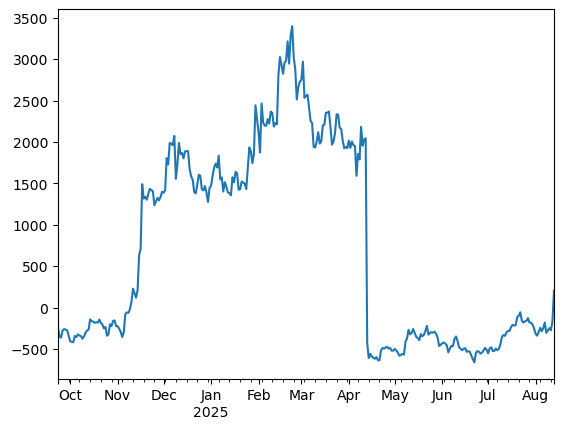

In [45]:
pnl_history['Total'].plot()

In [46]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-10:]

2025-08-04     50.440091
2025-08-05    -41.020054
2025-08-06     36.413389
2025-08-07     68.439267
2025-08-08   -124.710668
2025-08-09     28.638649
2025-08-10     28.580156
2025-08-11    -26.126058
2025-08-12    106.411481
2025-08-13    373.896725
Name: Total, dtype: float64

In [47]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-371.6021091919738, -950.5160328166933)

In [48]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [49]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [50]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [51]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [52]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [53]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [54]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

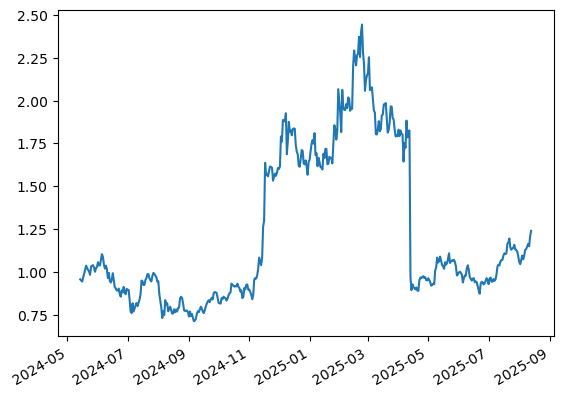

In [55]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

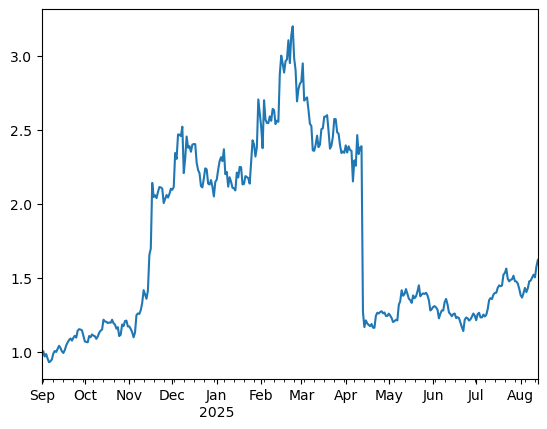

In [56]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [58]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [61]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [62]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [65]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.3753
WBTCUSDT,0.2352
TRXUSDT,0.2039
XRPUSDT,0.1023
OMUSDT,0.0403
ADAUSDT,0.0382
SUIUSDT,0.0048
HBARUSDT,0.0000
WBETHUSDT,0.0000
BTCUSDT,0.0000


In [66]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.370714
WBTCUSDT,0.266856
TRXUSDT,0.203310
XRPUSDT,0.115433
OMUSDT,0.038083
SUIUSDT,0.005604


In [67]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

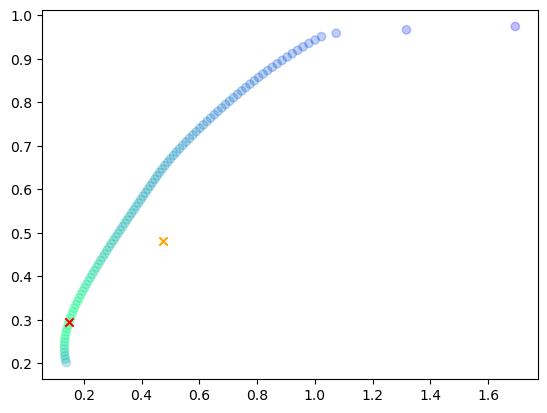

In [68]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [69]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [70]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1049.8304,0.4653,0.0000,0.4653
SOLUSDT,351.2670,0.1557,0.0000,0.1557
ETHUSDT,323.0963,0.1432,0.0000,0.1432
JASMYUSDT,217.0955,0.0962,0.0000,0.0962
TRXUSDT,176.7299,0.0783,0.0284,0.0499
OMUSDT,120.6902,0.0535,0.0050,0.0485
BNBUSDT,17.6360,0.0078,0.0507,-0.0429
BBUSDT,0.0014,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0006,-0.0006
PAXGUSDT,0.0000,0.0000,0.7421,-0.7421


### Current results

In [72]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [73]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.637382
TRXUSDT,0.362618


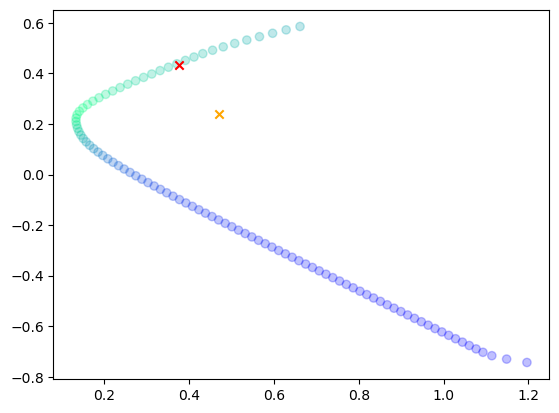

In [74]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [75]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1049.8304,0.4653,0.6374,-0.1721
SOLUSDT,351.2670,0.1557,0.0000,0.1557
ETHUSDT,323.0963,0.1432,0.0000,0.1432
JASMYUSDT,217.0955,0.0962,0.0000,0.0962
TRXUSDT,176.7299,0.0783,0.3626,-0.2843
OMUSDT,120.6902,0.0535,0.0000,0.0535
BNBUSDT,17.6360,0.0078,0.0000,0.0078
BBUSDT,0.0014,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [77]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [78]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

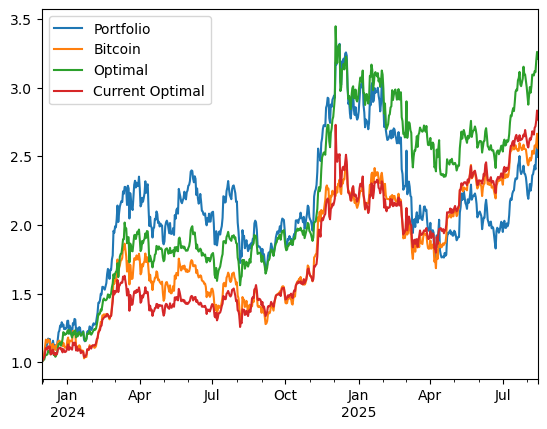

In [79]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [80]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

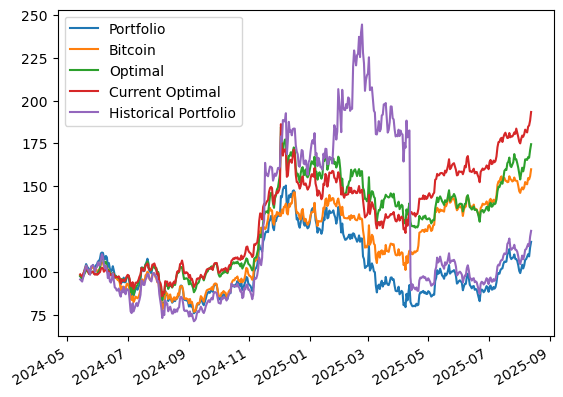

In [81]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [82]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-08-04,104.151182,149.337382,160.811293,179.553981,109.522079
2025-08-05,101.993307,148.131546,158.653015,178.825239,107.352682
2025-08-06,103.736123,149.246821,161.232343,180.359771,109.286764
2025-08-07,107.030070,152.431029,165.684926,183.025364,112.908559
2025-08-08,107.409476,151.392970,165.594911,182.113147,113.269675
2025-08-09,108.899149,151.116999,165.344285,181.391307,114.803097
2025-08-10,110.327506,154.747423,167.017453,184.774360,116.313837
2025-08-11,109.000182,153.956700,166.618210,185.486582,114.941611
2025-08-12,114.295493,155.823749,171.071206,188.347759,120.542351
2025-08-13,117.543614,159.885155,174.521074,193.331280,123.941736


## Volatilities

In [84]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.3767
 dtype: float64,
 0.37700015747253696)

In [85]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.471328
 dtype: float64,
 0.47132791748620834)

In [86]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.472479
Bitcoin            0.408267
Optimal            0.377000
Current Optimal    0.372053
dtype: float64

In [87]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5353175277251133

In [88]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

3.714876326286744

In [89]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.5068685703809801

## Risk Contribution

In [91]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,72.4777,0.3650,0.1874,0.1776
WBTCUSDT,41.7764,0.2274,0.0820,0.1455
TRXUSDT,29.1587,0.1906,0.1002,0.0904
XRPUSDT,21.5665,0.1409,0.0453,0.0955
SUIUSDT,0.6955,0.0078,0.0002,0.0076
OMUSDT,-38.5817,0.0684,0.0293,0.0391
Portfolio,127.0931,1.0000,0.4443,0.5557


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,41.210341,0.511311,0.428387,0.082924
TRXUSDT,38.562311,0.488689,0.405765,0.082924
Portfolio,79.772652,1.000000,0.834152,0.165848


In [93]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,30.087278,0.344550,0.145738,0.198812
TRXUSDT,8.423301,0.040915,0.012357,0.028559
ETHUSDT,2.032422,0.150440,0.030802,0.119638
BNBUSDT,0.239725,0.006496,0.000073,0.006423
SOLUSDT,-2.305616,0.204770,0.055022,0.149748
JASMYUSDT,-6.387634,0.175114,0.047792,0.127321
OMUSDT,-8.016520,0.077715,0.033702,0.044013
Portfolio,24.072955,1.000000,0.325486,0.674514


# Value At Risk

## Historical

### Optimal Weights

In [97]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.06463385352009035, -0.08131014249004218)

### Current Weights

In [99]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08128018037785949, -0.09799707322817151)

In [100]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [101]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.030604
SOLUSDT     -0.012631
ETHUSDT     -0.012029
JASMYUSDT   -0.016992
TRXUSDT     -0.003895
OMUSDT      -0.002814
BNBUSDT     -0.000664
BBUSDT      -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.079629
Name: 2025-03-09 00:00:00, dtype: float64

In [102]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025193
SOLUSDT     -0.019137
ETHUSDT     -0.013812
JASMYUSDT   -0.013394
TRXUSDT     -0.004170
OMUSDT      -0.018608
BNBUSDT     -0.000623
BBUSDT       0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.094936
dtype: float64

## Parametric

### Optimal Weights

In [105]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.0552479183752409, -0.06842816098734374)

### Current Weights

In [107]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.06907128762975974, -0.08554930807402956)

## Multivariate

### Optimal Weights

In [110]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.053155510613874093, -0.061036734855349335)

### Current Weights

In [112]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06731010841457069, -0.07756199926319604)

In [113]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.023177
SOLUSDT     -0.014165
ETHUSDT     -0.010710
JASMYUSDT   -0.011938
TRXUSDT     -0.002227
OMUSDT      -0.005604
BNBUSDT     -0.000439
Portfolio   -0.068260
dtype: float64

In [114]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.023033
SOLUSDT     -0.014491
ETHUSDT     -0.011207
JASMYUSDT   -0.012156
TRXUSDT     -0.002585
OMUSDT      -0.005354
BNBUSDT     -0.000451
Portfolio   -0.069278
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [118]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05255296332705146, -0.06083478494554437)

### Current Weights

In [120]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06720887618779126, -0.07927781059041888)

In [121]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [124]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05340300957811787, -0.06178717209279732)

### Current Weights

In [126]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07012931218821149, -0.08129194905459865)

In [127]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [130]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08142939732260543, -0.09668507144449988)

### Current Weights

In [132]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08807631573325042, -0.10482425227415032)

In [133]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [136]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [137]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.056508254365965044, -0.06399455209270838)

### Current Weights

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0698509819221304, -0.08046448435999688)

In [140]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [141]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.021363,-0.023252,-0.017122,-0.023177,-0.023188
SOLUSDT,-0.013670,-0.014365,-0.010242,-0.014165,-0.014372
ETHUSDT,-0.004954,-0.010673,-0.007246,-0.010710,-0.010535
JASMYUSDT,-0.007852,-0.011989,-0.009338,-0.011938,-0.012747
TRXUSDT,-0.002072,-0.002859,-0.002551,-0.002227,-0.003643
OMUSDT,-0.007701,-0.004520,-0.003095,-0.005604,-0.005052
BNBUSDT,0.000014,-0.000430,-0.000315,-0.000439,-0.000472
Portfolio,-0.057599,-0.068088,-0.049908,-0.068260,-0.070009


In [142]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.023402,-0.023422,-0.017145,-0.023033,-0.022692
SOLUSDT,-0.015907,-0.014841,-0.010048,-0.014491,-0.014805
ETHUSDT,-0.001515,-0.010275,-0.007287,-0.011207,-0.011071
JASMYUSDT,-0.007286,-0.012279,-0.009754,-0.012156,-0.013351
TRXUSDT,-0.002072,-0.002688,-0.002366,-0.002585,-0.003472
OMUSDT,-0.008140,-0.005154,-0.003492,-0.005354,-0.005083
BNBUSDT,0.000020,-0.000410,-0.000309,-0.000451,-0.000497
Portfolio,-0.058302,-0.069069,-0.050400,-0.069278,-0.070971


## VaR Violation

In [144]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.031452,-0.039965,-0.033886,0.007073
2023-12-31,-0.031452,-0.040076,-0.034199,-0.000971
2024-01-01,-0.031452,-0.040297,-0.032348,0.016534
2024-01-02,-0.031452,-0.040237,-0.033914,0.006186
2024-01-03,-0.031452,-0.041235,-0.036068,-0.021914
...,...,...,...,...
2025-08-10,-0.027211,-0.038123,-0.033185,0.010119
2025-08-11,-0.027211,-0.038135,-0.033307,-0.002390
2025-08-12,-0.027211,-0.039217,-0.034618,0.026726
2025-08-13,-0.027211,-0.039759,-0.034062,0.020166


In [145]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.024234,-0.078127,-0.068607,-0.016033
2024-05-29,-0.017747,-0.076051,-0.065142,-0.009014
2024-05-30,-0.017747,-0.064157,-0.060290,0.023635
2024-05-31,-0.017747,-0.063069,-0.055983,0.005881
2024-06-01,-0.017747,-0.061390,-0.055641,0.015606
...,...,...,...,...
2025-08-10,-0.030717,-0.047794,-0.047749,0.013116
2025-08-11,-0.030717,-0.047370,-0.047147,-0.012031
2025-08-12,-0.030717,-0.053300,-0.049716,0.048581
2025-08-13,-0.030717,-0.055040,-0.050185,0.028419


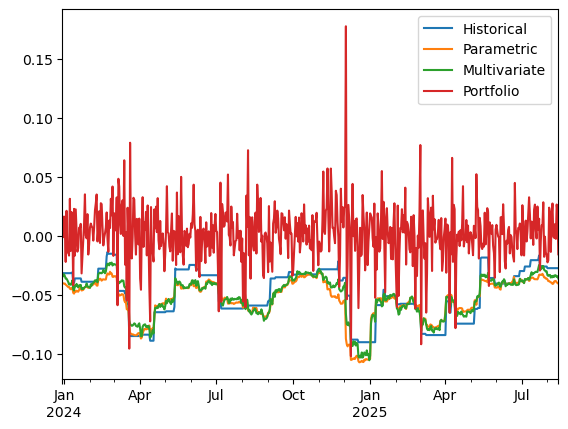

In [146]:
var_data.plot()
plt.show()

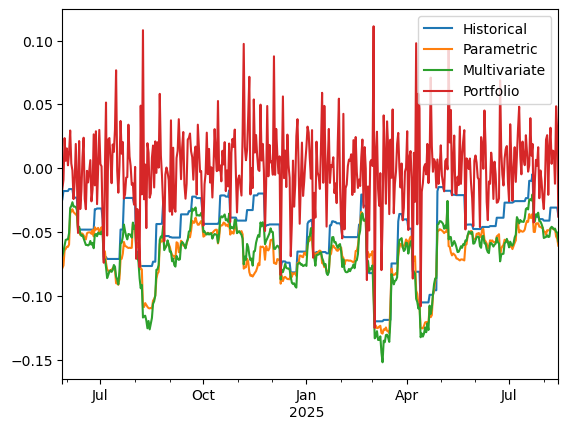

In [147]:
current_var_data.plot()
plt.show()


In [148]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031987,0.018519,0.016835
Kupiec Stat,4.626712,16.161415,18.308632
P-value,0.031478,0.000058,0.000019


In [149]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.065315,0.018018,0.015766
Kupiec Stat,2.008025,12.542359,14.782734
P-value,0.156469,0.000398,0.000121


# Principal Component Analysis

## Historical PCA

In [152]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59075905, 0.22682118, 0.07615878, 0.05865441, 0.04760658])

In [153]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.059672
AVAXUSDT     0.059919
BCHUSDT      0.045688
BNBUSDT      0.026506
BTCUSDT      0.030619
DOGEUSDT     0.062442
ETHUSDT      0.044218
HBARUSDT     0.060095
JASMYUSDT    0.069609
LINKUSDT     0.055813
LTCUSDT      0.042052
OMUSDT       0.067230
PAXGUSDT     0.000466
PEPEUSDT     0.079843
SOLUSDT      0.052670
SUIUSDT      0.058234
TRXUSDT      0.017411
USDCUSDT    -0.000155
WBETHUSDT    0.044220
WBTCUSDT     0.030409
XLMUSDT      0.047247
XRPUSDT      0.045794
Name: PC1, dtype: float64

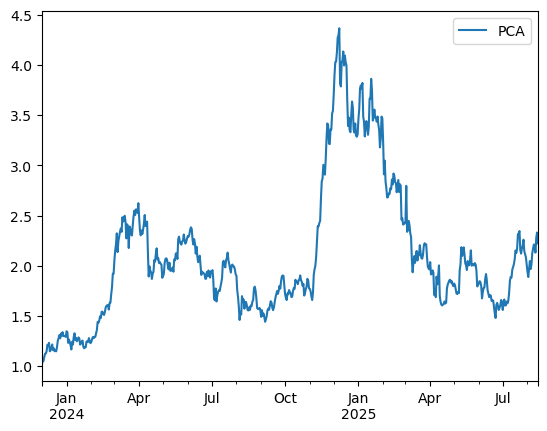

In [154]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

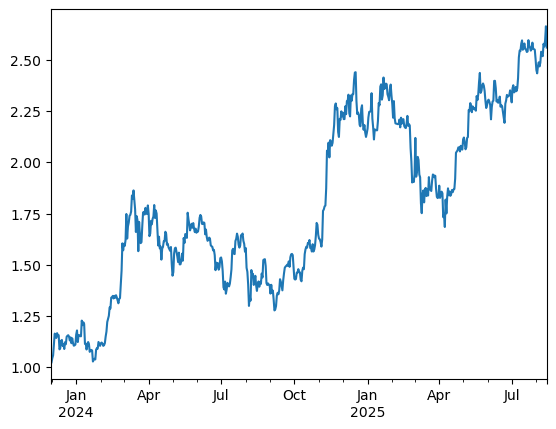

In [155]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [156]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.504828
ETHUSDT      0.505841
WBTCUSDT     0.550532
BTCUSDT      0.551266
AVAXUSDT     0.669821
SOLUSDT      0.673745
LINKUSDT     0.678397
DOGEUSDT     0.695435
BNBUSDT      0.710665
LTCUSDT      0.715136
ADAUSDT      0.729356
XRPUSDT      0.768771
BCHUSDT      0.834500
XLMUSDT      0.905505
USDCUSDT     0.948217
PAXGUSDT     0.961808
SUIUSDT      1.073569
TRXUSDT      1.083365
HBARUSDT     1.104317
dtype: float64

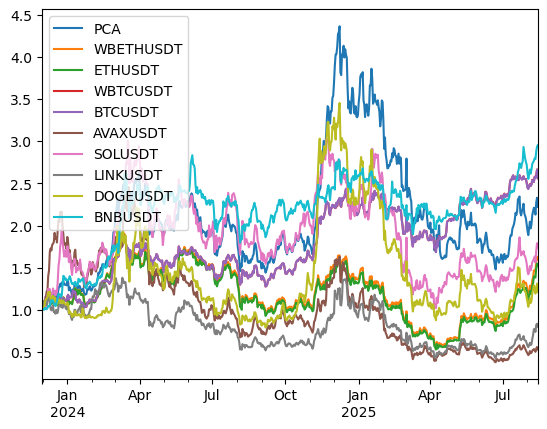

In [157]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

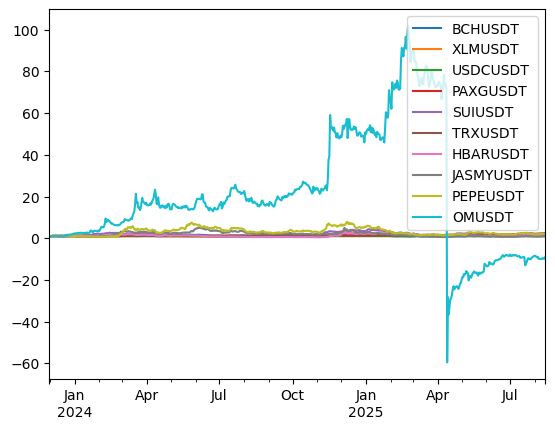

In [158]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [160]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52389894, 0.30267031, 0.0690171 , 0.06286696, 0.04154669])

In [161]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049584
SOLUSDT      0.092898
ETHUSDT      0.080814
JASMYUSDT    0.141544
TRXUSDT      0.034314
OMUSDT       0.241367
BNBUSDT      0.051044
BBUSDT       0.170004
PEPEUSDT     0.137420
PAXGUSDT     0.001011
Name: PC1, dtype: float64

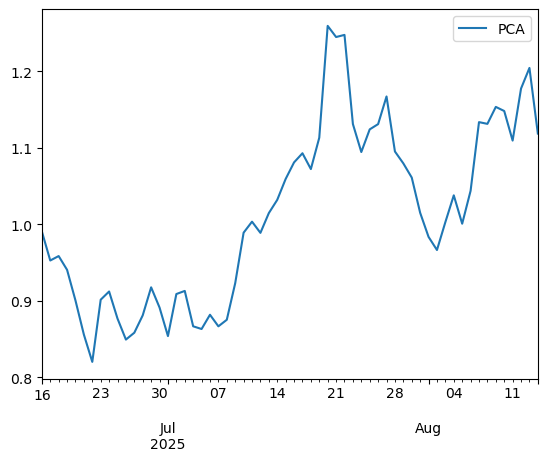

In [335]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

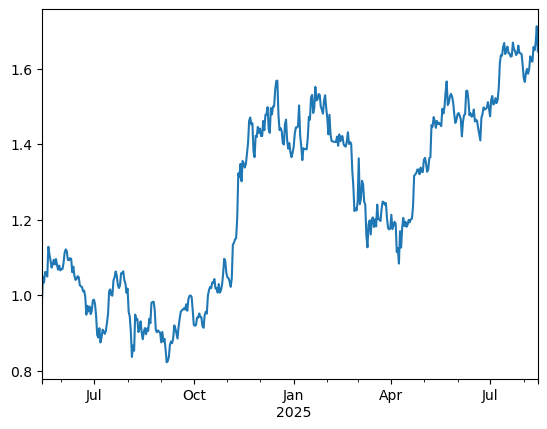

In [163]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [164]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.736082
SOLUSDT      0.773825
BTCUSDT      0.795479
BNBUSDT      0.798581
JASMYUSDT    0.977048
PEPEUSDT     1.011954
PAXGUSDT     1.057880
BBUSDT       1.079795
TRXUSDT      1.176724
dtype: float64

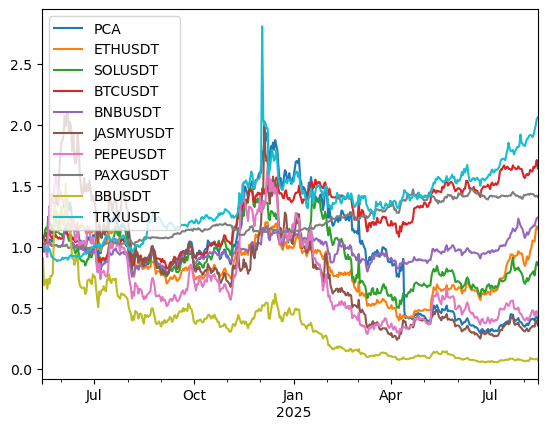

In [165]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [167]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.917456
BBUSDT       1.645057
JASMYUSDT    1.466849
SOLUSDT      1.284680
ETHUSDT      1.091821
BTCUSDT      1.000000
OMUSDT       0.990873
BNBUSDT      0.661937
TRXUSDT      0.329812
PAXGUSDT     0.028432
Name: BTCUSDT, dtype: float64

In [168]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       4.004744
JASMYUSDT    2.242799
SOLUSDT      1.849155
PEPEUSDT     1.840133
ETHUSDT      1.341547
BTCUSDT      1.000000
OMUSDT       0.908867
BNBUSDT      0.852079
TRXUSDT      0.302610
PAXGUSDT     0.092413
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [170]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [171]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
JASMYUSDT,0.219981
PEPEUSDT,0.205853
BNBUSDT,0.185642
TRXUSDT,0.154946
ETHUSDT,0.122382
SOLUSDT,0.062363
BBUSDT,0.058430
OMUSDT,0.056569
BTCUSDT,-0.022467
PAXGUSDT,-0.127974


### Regression to PCA

In [173]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.5153569908209505

In [174]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.310311
BNBUSDT      1.125119
PCA          1.000000
ETHUSDT      0.878696
SOLUSDT      0.724378
JASMYUSDT    0.462466
PEPEUSDT     0.457239
BBUSDT       0.368815
TRXUSDT      0.280623
PAXGUSDT     0.223301
OMUSDT       0.155495
dtype: float64

In [175]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.607831
BNBUSDT      1.308795
PCA          1.000000
PAXGUSDT     0.972951
ETHUSDT      0.903457
SOLUSDT      0.751353
PEPEUSDT     0.715218
JASMYUSDT    0.629632
TRXUSDT      0.389231
BBUSDT       0.266145
OMUSDT       0.247435
dtype: float64

### Correlation Matrix

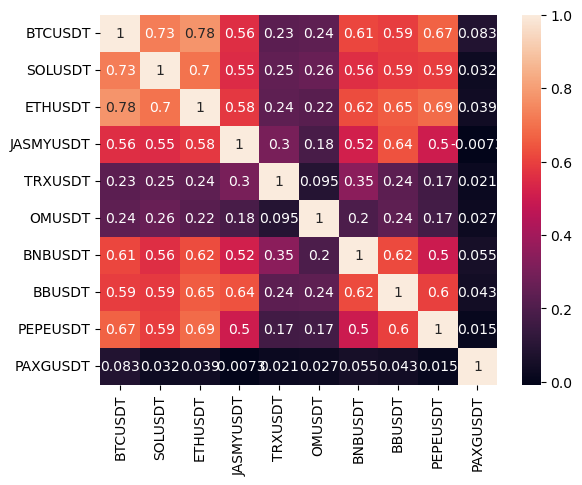

In [177]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

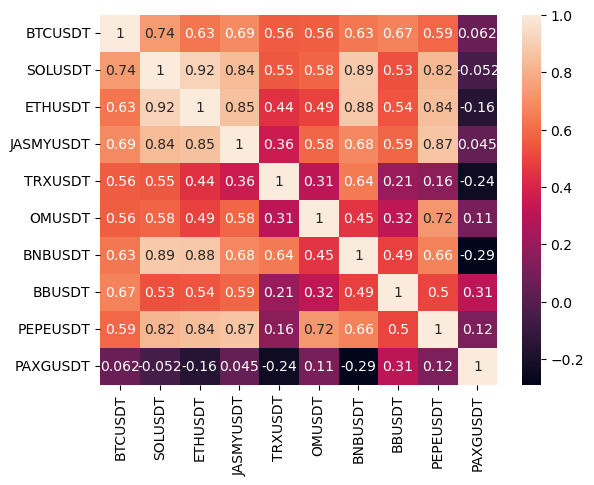

In [178]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [179]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [180]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

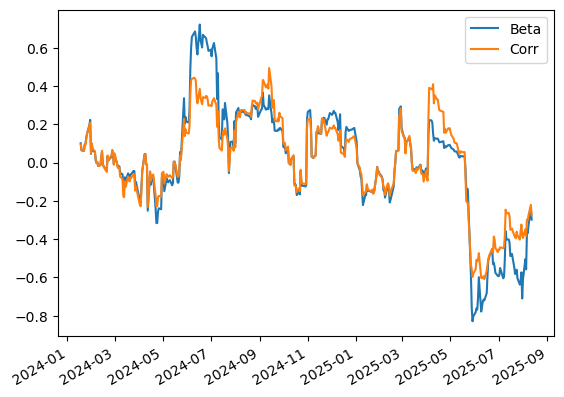

In [181]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [183]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BNBUSDT,BBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.000000,0.003604,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526887,0.176734,0.000000,0.000000,0.130357,0.000000


In [184]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [185]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,ADAUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,JASMYUSDT,LINKUSDT,...,PAXGUSDT,PEPEUSDT,SOLUSDT,SUIUSDT,TRXUSDT,USDCUSDT,WBETHUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
2025-01-06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.847998,0.0,0.0,0.152002,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2025-02-05,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.983247,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2025-03-07,0.0,0.0,0.295661,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.067591,0.0,0.0,0.000000,0.505689,0.0,0.000000,0.000000,0.000000,0.0
2025-04-06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2025-05-06,0.0,0.0,0.000312,0.0,0.0,0.0,0.0,0.0,0.002951,0.000000,...,0.685193,0.0,0.0,0.170798,0.057343,0.0,0.000000,0.000000,0.000000,0.0
2025-06-05,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.255886,0.0,0.0,0.000000,0.689091,0.0,0.055023,0.000000,0.000000,0.0
2025-07-05,0.0,0.0,0.807997,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.192003,0.000000,0.0
2025-08-04,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.484423,0.0,0.321642,0.000000,0.051924,0.0
2025-08-14,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.107898,...,0.000000,0.0,0.0,0.000000,0.892102,0.0,0.000000,0.000000,0.000000,0.0


In [186]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

TRXUSDT      0.484423
WBETHUSDT    0.321642
LTCUSDT      0.142011
XLMUSDT      0.051924
ADAUSDT      0.000000
PAXGUSDT     0.000000
Name: 2025-08-04 00:00:00, dtype: float64

<Axes: >

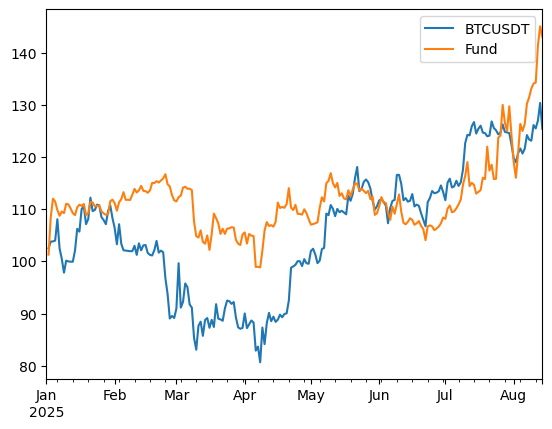

In [187]:
q=rebalanced_dynamic_quantities(data[returns_to_use.columns],rolling_optimization)
ptf=q*data[returns_to_use.columns]
comparison=pd.DataFrame()
comparison['BTCUSDT']=data['BTCUSDT']
comparison['Fund']=ptf.sum(axis=1)
((1+comparison.loc['2025'].pct_change()).cumprod()*100).plot()

In [188]:
(ptf-rebalanced_book_cost(data[returns_to_use.columns],q)).iloc[-1].sort_values(ascending=False)

SUIUSDT      96.374535
PAXGUSDT     75.208605
WBETHUSDT    23.261975
BCHUSDT      11.631240
TRXUSDT       8.395902
WBTCUSDT      2.931744
XLMUSDT       0.511153
ADAUSDT       0.000000
USDCUSDT      0.000000
SOLUSDT       0.000000
PEPEUSDT      0.000000
XRPUSDT       0.000000
AVAXUSDT      0.000000
LINKUSDT      0.000000
HBARUSDT      0.000000
ETHUSDT       0.000000
DOGEUSDT      0.000000
BTCUSDT       0.000000
BNBUSDT       0.000000
JASMYUSDT    -0.091059
LTCUSDT      -0.993004
OMUSDT       -3.580083
Name: 2025-08-14 00:00:00, dtype: float64

In [189]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
